# R(2+1)D Model on Webcam Stream

## Prerequisite for Webcam example
This notebook assumes you have a webcam connected to your machine. If you want to use a remote-VM to run the model and codes while using a local machine for the webcam stream, you can use an SSH tunnel:

1. SSH connect to your VM:
`$ ssh -L 8888:localhost:8888 <user-id@url-to-your-vm>`
1. Launch a Jupyter session on the VM (with port 8888 which is the default)
1. Open localhost:8888 from your browser on the webcam connected local machine to access the Jupyter notebook running on the VM.

We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, the widget works on Chrome and Firefox. For more details about the widget, please visit [ipywebrtc github](https://github.com/maartenbreddels/ipywebrtc).

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")
from collections import deque
import io
import os
from time import sleep, time
from threading import Thread

import decord
import IPython.display
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, HTML, Layout, VBox, Widget, Label
import numpy as np
from PIL import Image
import torch
import torch.cuda as cuda
import torch.nn as nn
from torchvision.transforms import Compose

from utils_cv.action_recognition.data import KINETICS
from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.action_recognition.references import transforms_video as transforms
from utils_cv.common.gpu import system_info

system_info()

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla V100-PCIE-16GB


## Load Pre-trained Model

Load R(2+1)D 34-layer model pre-trained on IG65M and fine-tuned on Kinetics400. There are two versions of the model: 8-frame model and 32-frame model based on the input clip length. The 32-frame model is slower than 8-frame model.

In [3]:
NUM_CLASSES = 400
NUM_FRAMES = 8    # 8 or 32.
IM_SCALE = 128    # resize then crop
INPUT_SIZE = 112  # input clip size: 3 x NUM_FRAMES x 112 x 112
# Normalization
MEAN = (0.43216, 0.394666, 0.37645)
STD = (0.22803, 0.22145, 0.216989)

In [4]:
model, model_name = VideoLearner.init_model(
    sample_length=NUM_FRAMES,
    base_model='kinetics'
)

Loading r2plus1d_34_8_kinetics model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


### Prepare class names
Since we use Kinetics400 model out of the box, we load its class names. The dataset consists of 400 human actions. For example, the first 20 labels are:

In [5]:
labels = KINETICS.class_names
labels[:20]

['abseiling',
 'air drumming',
 'answering questions',
 'applauding',
 'applying cream',
 'archery',
 'arm wrestling',
 'arranging flowers',
 'assembling computer',
 'auctioning',
 'baby waking up',
 'baking cookies',
 'balloon blowing',
 'bandaging',
 'barbequing',
 'bartending',
 'beatboxing',
 'bee keeping',
 'belly dancing',
 'bench pressing']

Among them, we will use 50 classes that we are interested in (i.e. the actions make sense to demonstrate in front of the webcam) and ignore other classes by filtering out from the model outputs.

In [6]:
REL_LABELS = [
    "assembling computer",
    "applying cream",
    "brushing teeth",
    "clapping",
    "cleaning floor",
    "cleaning windows",
    "drinking",
    # will regard all eatings as simply "eating"
    "eating burger",
    "eating chips",
    "eating doughnuts",
    "eating hotdog",
    "eating ice cream",
    "fixing hair",
    "hammer throw",
    # will regards all kicking as simply "kicking"
    "high kick",
    # will regards jogging and running on treadmill as "running"
    "jogging",
    "laughing",
    "mopping floor",
    "moving furniture",
    "opening bottle",
    "plastering",
    # will regards all punching as simply "punching"
    "punching bag",
    "punching person (boxing)",
    "pushing cart",
    # will regard all readings as simply "reading"
    "reading book",
    "reading newspaper",
    "rock scissors paper",
    "running on treadmill",
    "shaking hands",
    "shaking head",
    "side kick",
    "slapping",
    "smoking",
    "sneezing",
    "spray painting",
    "spraying",
    "stretching arm",
    "stretching leg",
    "sweeping floor",
    "swinging legs",
    "texting",
    # will regards all throwing as simply "throwing"
    "throwing axe",
    "throwing ball",
    "unboxing",
    "unloading truck",
    "using computer",
    "using remote controller (not gaming)",
    "welding",
    "writing",
    "yawning",
]
len(REL_LABELS)

50

### Load model to device

In [7]:
if cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
model.eval()

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=Tru

## Run Model
Here, we use a sliding window classification for action recognition on the continuous webcam stream. We average the last 5 windows results to smoothing out the prediction results. We also reject classes that the score is less than `SCORE_THRESHOLD`. 

In [8]:
SCORE_THRESHOLD = 0.04
AVERAGING_SIZE = 5  # Averaging 5 latest clips to make video-level prediction (or smoothing)

In [9]:
transform = Compose([
    transforms.ToTensorVideo(),
    transforms.ResizeVideo(IM_SCALE),
    transforms.CenterCropVideo(INPUT_SIZE),
    transforms.NormalizeVideo(MEAN, STD)
])

In [10]:
def predict(frames, transform, device, model):
    clip = torch.from_numpy(np.array(frames))
    # Transform frames and append batch dim
    sample = torch.unsqueeze(transform(clip), 0)
    sample = sample.to(device)
    output = model(sample)
    scores = nn.functional.softmax(output, dim=1).data.cpu().numpy()[0]
    
    return scores

def filter_labels(
    id_score_dict,
    labels,
    threshold=0.0,
    target_labels=None,
    filter_labels=None
):
    # Show only interested actions (target_labels) with a confidence score >= threshold
    result = {}
    for i, s in id_score_dict.items():
        l = labels[i]
        if (s < threshold) or\
           (target_labels is not None and l not in target_labels) or\
           (filter_labels is not None and l in filter_labels):
            continue
        
        # Simplify some labels
        if l.startswith('eating'):
            l = 'eating'
        elif l.startswith('reading'):
            l = 'reading'
        elif l.startswith('punching'):
            l = 'punching'
        elif l.startswith('throwing'):
            l = 'throwing'
        elif l.endswith('kick'):
            l = 'kicking'
        elif l == 'jogging' or l == 'running on treadmill':
            l = 'running'

        if l in result:
            result[l] += s
        else:
            result[l] = s
            
    return result

### On Webcam Stream
#### Start webcam

In [11]:
# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': {'width': 400, 'height': 400}
    },
    layout=Layout(width='400px')
)

# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(
    format='jpg',
    stream=w_cam,
    layout=Layout(padding='0 0 0 100px')
)

# Text widget to show our classification results
w_text = HTML(layout=Layout(padding='0 0 0 100px'))

def predict_webcam_frames():
    """ Predict activity by using a pretrained model
    """
    global w_imrecorder, w_text, is_playing
    global device, model
    
    # Use deque for sliding window over frames
    window = deque()
    scores_cache = deque()
    scores_sum = np.zeros(NUM_CLASSES)
    
    while is_playing:
        try:
            # Get the image (RGBA) and convert to RGB
            im = Image.open(
                io.BytesIO(w_imrecorder.image.value)
            ).convert('RGB')     
            window.append(np.array(im))
            if len(window) == NUM_FRAMES:
                # Make a prediction
                t = time()
                scores = predict(window, transform, device, model)
                dur = time() - t
                # Averaging scores across clips (dense prediction)
                scores_cache.append(scores)
                scores_sum += scores
                if len(scores_cache) == AVERAGING_SIZE:
                    scores_avg = scores_sum / AVERAGING_SIZE
                    # 1. Pick top-5 labels 
                    top5_id_score_dict = {
                        i: scores_avg[i] for i in (-scores_avg).argpartition(4)[:5]
                    }
                    # 2. Filter by SCORE_THRESHOLD and REL_LABELS
                    top5_label_score_dict = filter_labels(
                        top5_id_score_dict,
                        labels,
                        threshold=SCORE_THRESHOLD,
                        target_labels=REL_LABELS
                    )
                    # 3. Display the labels sorted by scores
                    top5 = sorted(
                        top5_label_score_dict.items(), key=lambda kv: -kv[1]
                    )
                    # Plot final results nicely
                    w_text.value = (
                        "{} fps<p style='font-size:20px'>".format(1//dur) + "<br>".join([
                            "{} ({:.3f})".format(k, v) for k, v in top5
                        ]) + "</p>"
                    )
                    scores_sum -= scores_cache.popleft()
                window.popleft()
            else:
                w_text.value = "Preparing..."     
        except OSError:
            # If im_recorder doesn't have valid image data, skip it. 
            pass
        except BaseException as e:
            w_text.value = "Exception: " + str(e)
            break

        # Taking the next snapshot programmatically
        w_imrecorder.recording = True
        sleep(0.02)

is_playing = False
#  Once prediciton started, hide image recorder widget for faster fps
def start(_):
    global is_playing
    # Make sure this get called only once
    if not is_playing:
        w_imrecorder.layout.display = 'none'
        is_playing = True
        Thread(target=predict_webcam_frames).start()
    
w_imrecorder.image.observe(start, 'value')


In [12]:
HBox([w_cam, w_imrecorder, w_text])

To start inference on webcam stream, click 'capture' button when the stream is started.

#### Stop Webcam and clean-up

In [13]:
is_playing = False
Widget.close_all()

### Appendix: Run on a video file
Here, we show how to use the model on a video file. We utilize threading so that the inference does not block the video preview.
* Prerequisite - Download HMDB51 video files from [here](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/#Downloads)

In [14]:
def _predict_video_frames(window, scores_cache, scores_sum, is_ready):
    t = time()
    scores = predict(window, transform, device, model)
    dur = time() - t
    # Averaging scores across clips (dense prediction)
    scores_cache.append(scores)
    scores_sum += scores
    if len(scores_cache) == AVERAGING_SIZE:
        scores_avg = scores_sum / AVERAGING_SIZE
        top5_id_score_dict = {
            i: scores_avg[i] for i in (-scores_avg).argpartition(4)[:5]
        }
        top5_label_score_dict = filter_labels(
            top5_id_score_dict,
            labels, 
            threshold=SCORE_THRESHOLD,
        )
        top5 = sorted(top5_label_score_dict.items(), key=lambda kv: -kv[1])
        # Plot final results nicely
        d_caption.update(IPython.display.HTML(
            "{} fps<p style='font-size:20px'>".format(1 // dur) + "<br>".join([
                "{} ({:.3f})".format(k, v) for k, v in top5
            ]) + "</p>"
        ))
        scores_sum -= scores_cache.popleft()
    
    # Inference done. Ready to run on the next frames.
    window.popleft()
    is_ready[0] = True

def predict_video_frames(video_filepath, d_video, d_caption):
    """Load video and show frames and inference results on
    d_video and d_caption displays
    """
    video_reader = decord.VideoReader(video_filepath)
    print("Total frames = {}".format(len(video_reader)))
    
    is_ready = [True]
    window = deque()
    scores_cache = deque()
    scores_sum = np.zeros(NUM_CLASSES)
    while True:
        try:
            frame = video_reader.next().asnumpy()
            if len(frame.shape) != 3:
                break
            
            # Start an inference thread when ready
            if is_ready[0]:
                window.append(frame)
                if len(window) == NUM_FRAMES:
                    is_ready[0] = False
                    Thread(
                        target=_predict_video_frames,
                        args=(window, scores_cache, scores_sum, is_ready)
                    ).start()
                    
            # Show video preview
            f = io.BytesIO()
            im = Image.fromarray(frame)
            im.save(f, 'jpeg')

            d_video.update(IPython.display.Image(data=f.getvalue()))
            sleep(0.03)
        except:
            break


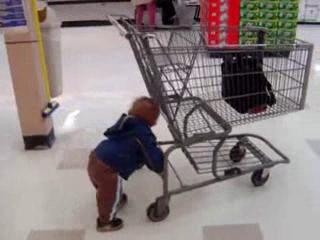

Total frames = 80


In [15]:
video_filepath = os.path.join(
    "../../data/misc", "hmdb51", "videos",
    "push", "Baby_Push_Cart_push_f_cm_np1_ri_bad_0.avi"
)

d_video = IPython.display.display("", display_id=1)
d_caption = IPython.display.display("Preparing...", display_id=2)

try:
    predict_video_frames(video_filepath, d_video, d_caption)
except decord.DECORDError:
    print("invalid video path")
    pass
except KeyboardInterrupt:
    pass